# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
print(data.columns.values)

['number_of_elements' 'mean_atomic_mass' 'wtd_mean_atomic_mass'
 'gmean_atomic_mass' 'wtd_gmean_atomic_mass' 'entropy_atomic_mass'
 'wtd_entropy_atomic_mass' 'range_atomic_mass' 'wtd_range_atomic_mass'
 'std_atomic_mass' 'wtd_std_atomic_mass' 'mean_fie' 'wtd_mean_fie'
 'gmean_fie' 'wtd_gmean_fie' 'entropy_fie' 'wtd_entropy_fie' 'range_fie'
 'wtd_range_fie' 'std_fie' 'wtd_std_fie' 'mean_atomic_radius'
 'wtd_mean_atomic_radius' 'gmean_atomic_radius' 'wtd_gmean_atomic_radius'
 'entropy_atomic_radius' 'wtd_entropy_atomic_radius' 'range_atomic_radius'
 'wtd_range_atomic_radius' 'std_atomic_radius' 'wtd_std_atomic_radius'
 'mean_Density' 'wtd_mean_Density' 'gmean_Density' 'wtd_gmean_Density'
 'entropy_Density' 'wtd_entropy_Density' 'range_Density'
 'wtd_range_Density' 'std_Density' 'wtd_std_Density'
 'mean_ElectronAffinity' 'wtd_mean_ElectronAffinity'
 'gmean_ElectronAffinity' 'wtd_gmean_ElectronAffinity'
 'entropy_ElectronAffinity' 'wtd_entropy_ElectronAffinity'
 'range_ElectronAffinity' 'w

In [4]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.

In [5]:
dim_notebook = len(data.columns) - 1
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [6]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [7]:
X_data = data.loc[:, data.columns != "critical_temp"]
Y_data = data.loc[:, data.columns == "critical_temp"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [8]:
#Data normalisation
X_data = scale(X_data)
Y_data = scale(Y_data)

In [9]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")


# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  2126
There is 10 devices.
torch.Size([2126, 82])


In [10]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [11]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=20000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-obj_min")

   it    |   obj   
    4000 | 1.9810e-01
    8000 | 1.9220e-01
   12000 | 1.8962e-01
   16000 | 1.8814e-01
Gradient Descent: execution time=124.931 seconds
Final loss : 0.18715

CPU times: user 8min 6s, sys: 3.45 s, total: 8min 9s
Wall time: 2min 4s


Text(0.5, 0, 'true value (normalized)')

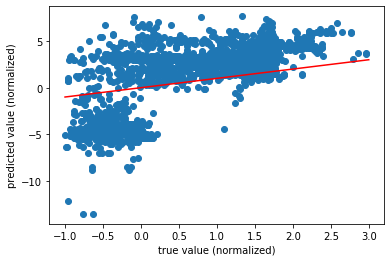

In [12]:
plt.scatter(Y[0], X[0].mv(obj_min_by_N_descent.model_params[-1]))
plt.plot(np.linspace(-1, 3, 2), np.linspace(-1, 3, 2), color='r')
plt.ylabel("predicted value (normalized)")
plt.xlabel("true value (normalized)")

In [13]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models = cost_models, 
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [00:09<00:37,  9.40s/it]

QSGD


 40%|████      | 2/5 [00:29<00:37, 12.51s/it]

Diana


 60%|██████    | 3/5 [00:48<00:29, 14.64s/it]

BiQSGD


 80%|████████  | 4/5 [01:08<00:16, 16.25s/it]

Artemis


100%|██████████| 5/5 [01:30<00:00, 18.14s/it]

CPU times: user 1min 38s, sys: 137 ms, total: 1min 39s
Wall time: 1min 30s


In [14]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-0.3851,  0.0996,  0.0173, -0.0050,  0.0067,  0.0009,  0.0676,  0.1282,
         0.0839, -0.0723,  0.0457, -0.0035, -0.0100,  0.0210, -0.0229,  0.0113,
         0.0650,  0.0496,  0.0800,  0.0090,  0.0521,  0.0617,  0.1071,  0.0352,
         0.0481, -0.0056,  0.0634,  0.0919,  0.1119, -0.0619,  0.0792,  0.0853,
        -0.0303, -0.0194, -0.0661, -0.0534,  0.0588,  0.0434,  0.0352, -0.0020,
         0.0110,  0.0176, -0.0758, -0.0052, -0.1275, -0.0809, -0.0011, -0.0349,
         0.0224, -0.0035,  0.0426,  0.0534, -0.0411, -0.0499, -0.0447, -0.0505,
         0.0964,  0.1072, -0.0609, -0.0422, -0.0673, -0.0850,  0.1109,  0.1791,
        -0.0733, -0.0807, -0.0121, -0.1065,  0.1613,  0.1872,  0.1468,  0.2128,
        -0.0893, -0.1099, -0.0709, -0.0933,  0.0798,  0.0964, -0.1210, -0.0747,
        -0.1301, -0.1994], dtype=torch.float64)


## With averaging

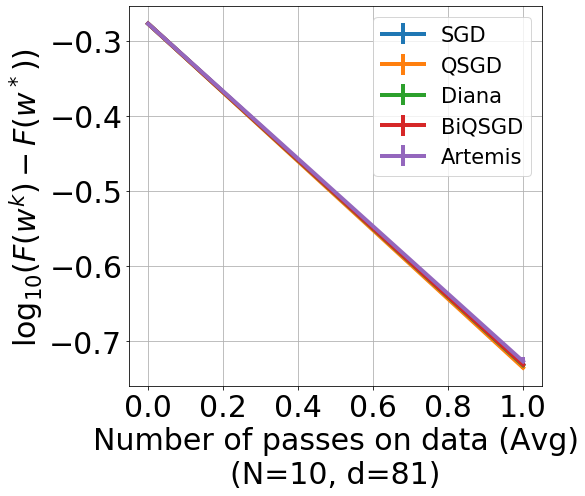

In [15]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

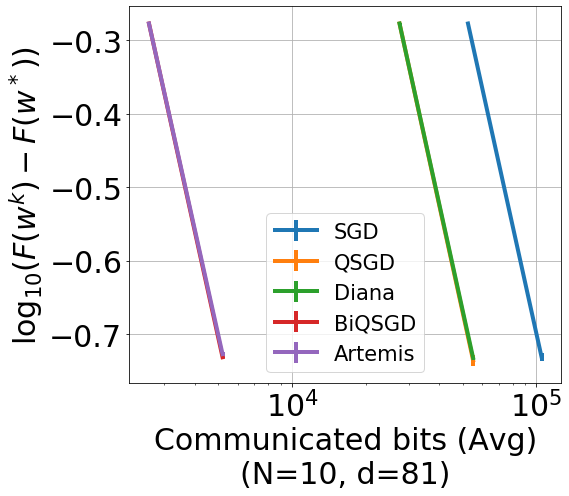

In [16]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

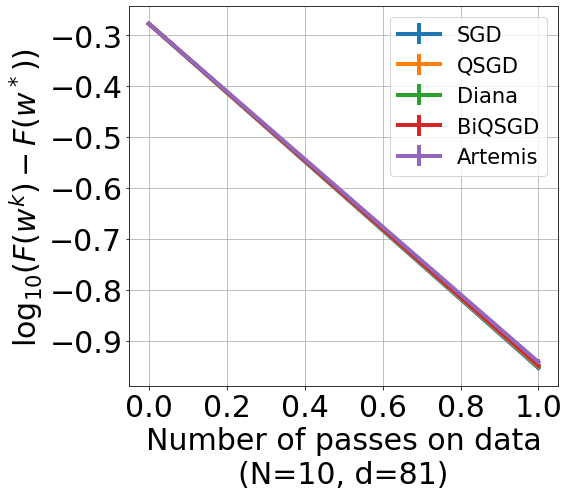

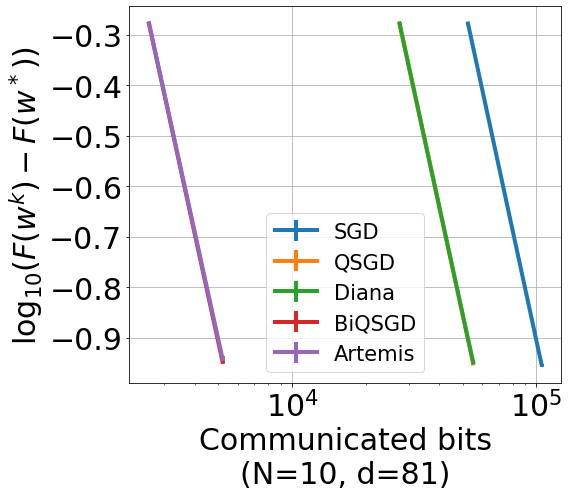

In [17]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

# Handling non-iid data

There is 10 devices.
Number of points on device 0 : 1161
Number of points on device 1 : 4781
Number of points on device 2 : 3084
Number of points on device 3 : 1106
Number of points on device 4 : 1279
Number of points on device 5 : 2669
Number of points on device 6 : 866
Number of points on device 7 : 4435
Number of points on device 8 : 657
Number of points on device 9 : 1225
CPU times: user 31.7 s, sys: 304 ms, total: 32 s
Wall time: 8.09 s


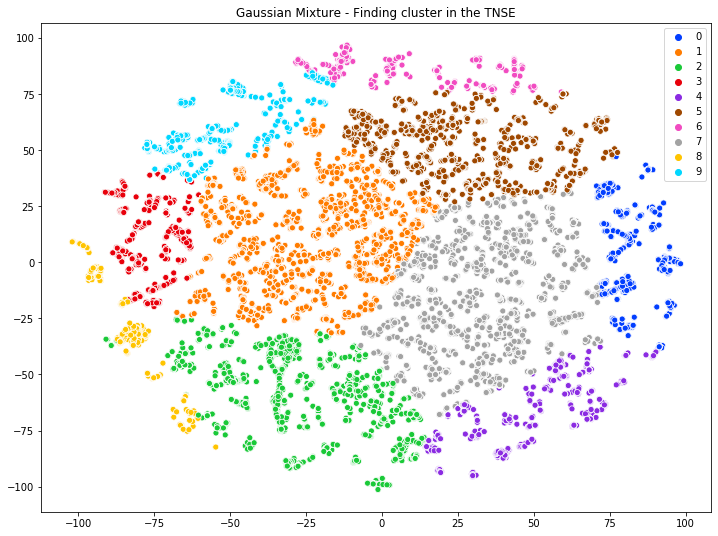

In [57]:
%%time
nb_cluster = nb_devices_for_the_run
embedded_data = pickle_loader(filename + "-tsne")
# Finding clusters in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "critical_temp", nb_cluster, scale_Y=True)
dim_notebook = X[0].shape[1]

In [58]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [59]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=20000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min_by_N = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    4000 | 2.2836e-01
    8000 | 2.2103e-01
   12000 | 2.1780e-01
   16000 | 2.1583e-01
Gradient Descent: execution time=82.058 seconds
Final loss : 0.21444

CPU times: user 5min 25s, sys: 1.98 s, total: 5min 26s
Wall time: 1min 22s


## Batch size $= 1$ (stochastic)

In [20]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=True,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [00:05<00:20,  5.11s/it]

QSGD


 40%|████      | 2/5 [00:16<00:20,  6.88s/it]

Diana


 60%|██████    | 3/5 [00:26<00:16,  8.05s/it]

BiQSGD


 80%|████████  | 4/5 [00:39<00:09,  9.51s/it]

Artemis


100%|██████████| 5/5 [00:51<00:00, 10.37s/it]

CPU times: user 59.2 s, sys: 92.1 ms, total: 59.3 s
Wall time: 51.9 s


In [21]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-0.3811,  0.0980,  0.0206, -0.0050,  0.0059, -0.0008,  0.0656,  0.1297,
         0.0893, -0.0712,  0.0540,  0.0029, -0.0030,  0.0172, -0.0125,  0.0089,
         0.0666,  0.0515,  0.0746,  0.0120,  0.0448,  0.0540,  0.1028,  0.0366,
         0.0442, -0.0046,  0.0639,  0.0909,  0.1116, -0.0566,  0.0783,  0.0856,
        -0.0280, -0.0181, -0.0668, -0.0548,  0.0578,  0.0457,  0.0365,  0.0036,
         0.0134,  0.0215, -0.0764, -0.0071, -0.1266, -0.0806,  0.0016, -0.0337,
         0.0197, -0.0011,  0.0398,  0.0427, -0.0465, -0.0521, -0.0496, -0.0527,
         0.0947,  0.1056, -0.0650, -0.0403, -0.0702, -0.0877,  0.1126,  0.1881,
        -0.0694, -0.0761, -0.0165, -0.1108,  0.1617,  0.1953,  0.1477,  0.2162,
        -0.0910, -0.1088, -0.0721, -0.0920,  0.0814,  0.0964, -0.1260, -0.0680,
        -0.1319, -0.1999], dtype=torch.float64)


## With averaging

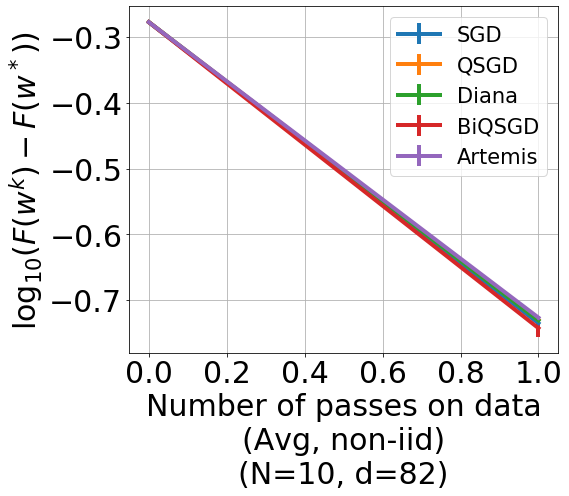

In [22]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 

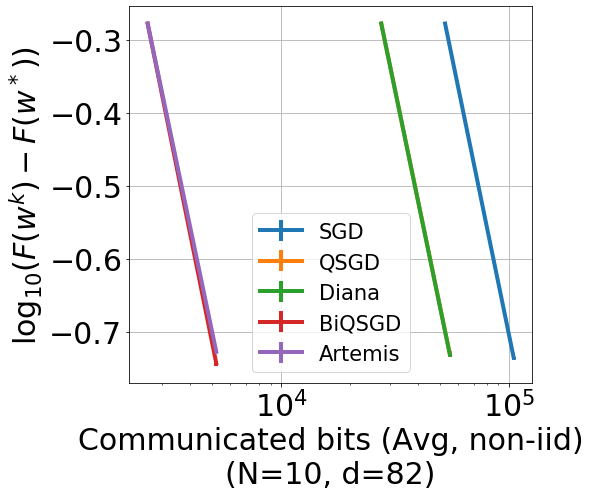

In [23]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, non-iid)") 


## Without averaging

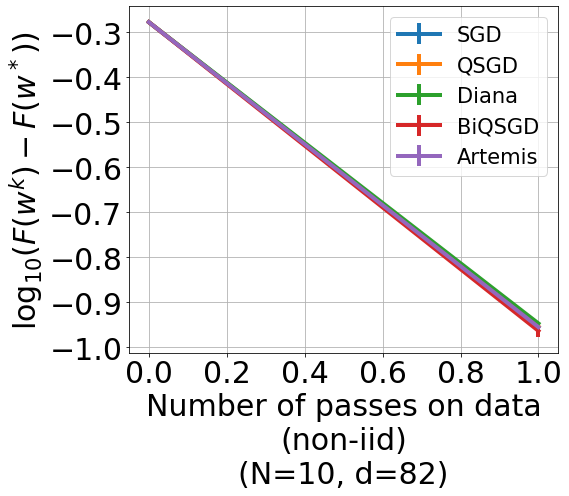

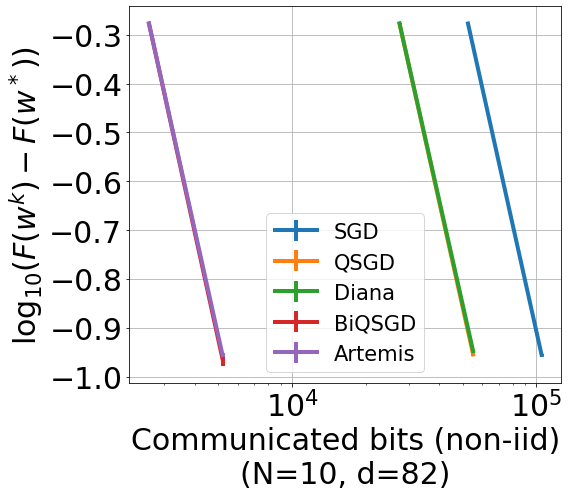

In [24]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 

## Batch size $= 200$ (stochastic)

In [85]:
%%time
batch_size = 300
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=False, batch_size=batch_size, 
                                               nb_epoch=200, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-{0}".format(batch_size))

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
large dim, big batch
large dim, big batch


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

QSGD
large dim, big batch
large dim, big batch


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

Diana
large dim, big batch
large dim, big batch


 60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

BiQSGD
large dim, big batch
large dim, big batch


 80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

Artemis
large dim, big batch
large dim, big batch


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

CPU times: user 1min, sys: 488 ms, total: 1min 1s
Wall time: 15.4 s


In [53]:
cost_models[7].X.shape

torch.Size([4435, 82])

In [26]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-4.6534,  0.3727, -0.3968,  0.1399, -0.4855,  0.4669, -0.8215,  0.9419,
         1.8023, -0.6246,  0.9257, -0.4444,  0.5866,  0.3993,  1.1492,  0.7747,
        -0.0268, -0.2969, -0.1486, -0.2750, -1.2342, -1.0137,  0.5621,  0.9209,
        -0.1779,  0.2257, -0.2140,  0.5609,  1.3660, -0.7617,  0.5508,  1.0229,
        -0.6521, -0.1860, -0.7462, -0.3135,  0.2811, -0.3432, -0.6413,  0.0410,
        -0.3326, -0.3966,  0.1385, -0.1787,  0.4656, -0.9695, -0.2399, -1.2318,
        -0.4353, -1.1522,  0.5414,  0.0864,  0.2747,  0.1715, -0.2113, -0.1595,
         0.3658,  0.9392, -0.1857,  0.2679, -0.2713, -0.2598,  0.1296,  0.9434,
        -0.6620, -1.2763,  0.6451,  0.3214,  0.3677,  0.4089,  0.0582,  1.4093,
        -0.0301, -0.3750, -0.1325, -0.3205, -0.2253, -0.1550,  0.3159,  0.7958,
         0.6390, -1.7703], dtype=torch.float64)


## With averaging

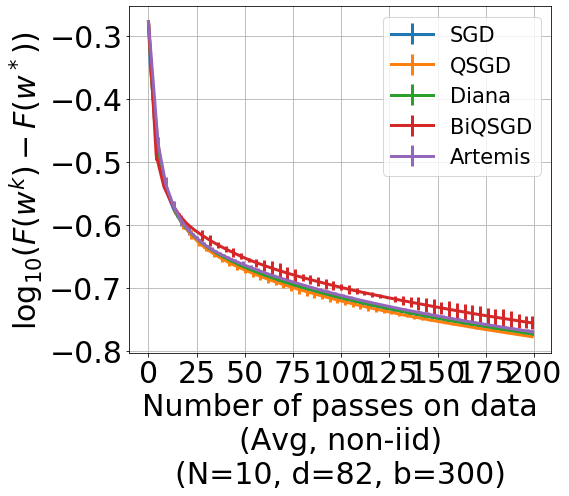

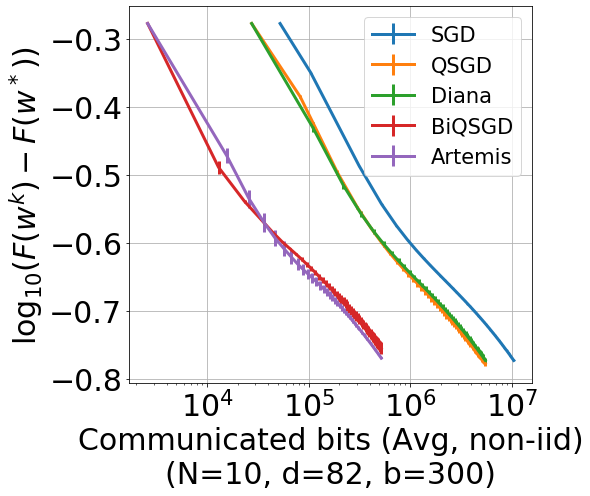

In [86]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent-{0}".format(batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Communicated bits (Avg, non-iid)") 

## Without averaging

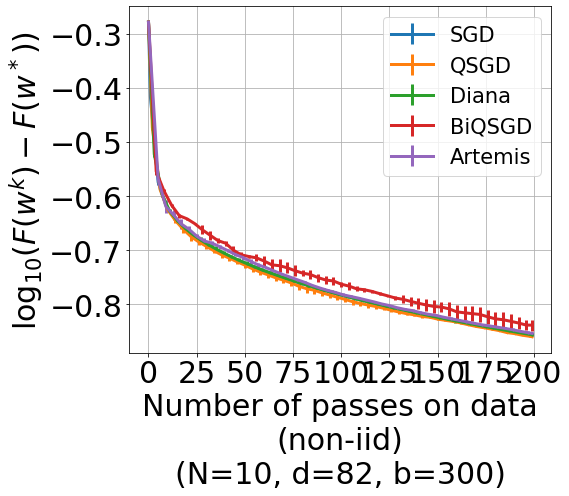

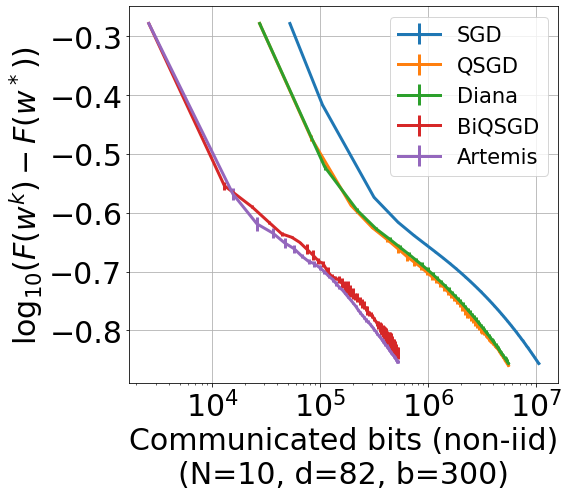

In [87]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent-{0}".format(batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,  batch_size=batch_size,
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 